import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.util import ngrams
from nltk.corpus import stopwords
set(stopwords.words('english'))

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from gensim import corpora, models, similarities, matutils

from wordcloud import WordCloud

#import umap
import seaborn as sns
import sklearn.cluster as cluster

import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models



In [1]:
import pandas as pd 
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting
import seaborn as sns

from sklearn import preprocessing

import nltk
#nltk.download('stopwords')
#nltk.download('words')

from nltk.corpus import stopwords
set(stopwords.words('english'))

from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

import string
import re
#import contractions
import warnings

#from my_functions import *
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

#JP 
corpus_list = []
with open("pmc_result-2.txt", "r") as f:
    f = f.readlines()
    doc_list = []
    for line in f:
        # print(line, "/")
        if len(line) > 4 and line[4] == '-' and len(doc_list) == 0:
            line = line.replace('\n', ' ').strip()
            doc_list.append(line)
        elif len(line) > 4 and line[4] != '-':
            line = line.replace('\n', ' ').strip()
            doc_list.append(line)
        elif len(line) > 4 and line[4] == '-' and len(doc_list) > 0:
            line = line.replace('\n', ' ').strip()
            #corpus_list.append(' '.join(doc_list))
            corpus_list.append(' '.join(doc_list))
            doc_list = []
            doc_list.append(line)
df_raw = pd.DataFrame(corpus_list) #JL df=pd.read_csv('pmc_result-2.txt',delimiter='\t',header=None) 


dict_dp = {} 
for i in df_raw[0]:
    #mini_list=[]
    if 'PMC' in i.split(' - ')[0]:
        #mini_list.append(i)
        dp=i
    if 'TI' in i.split(' - ')[0]:
        title=i
    if 'AB' in i.split(' - ')[0]:
        dict_dp[dp]=list([title,i])
    else:
        pass
df_dp = pd.DataFrame.from_dict(dict_dp, orient ='index') 

In [2]:
#df_dp.to_pickle("abstract_pmc_title.pkl")  
df1 = pd.read_pickle("abstract_pmc_title.pkl")  #note that df dp became df1

In [32]:
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 56024 rows and 2 columns


In [3]:
df1.head(2)

,0,1
PMC - PMC8623061,TI - The Safe and Effective Use of Plant-Base...,"AB - Plant-based diets, defined here as inclu..."
PMC - PMC7176641,TI - Prevalence and psychopathology of vegeta...,AB - The aim of the study was to investigate ...


In [4]:
df_abstractetc = df1.reset_index()

In [5]:
df_abstractetc.rename(columns = {'index':'pmc',0:'title', 1:'abstract'}, inplace=True)

In [6]:
df_abstractetc.head(3)

,pmc,title,abstract
0,PMC - PMC8623061,TI - The Safe and Effective Use of Plant-Base...,"AB - Plant-based diets, defined here as inclu..."
1,PMC - PMC7176641,TI - Prevalence and psychopathology of vegeta...,AB - The aim of the study was to investigate ...
2,PMC - PMC8746448,TI - Nutrient Intake and Status in Adults Con...,AB - Health authorities increasingly recommen...


In [2]:
#df_abstractetc.to_pickle("abstract_pmc_titlev2.pkl")  # Save a copy
#df = pd.read_pickle("abstract_pmc_titlev2.pkl") 

In [5]:
# search the key words terms in abstract
key_words = ['vegetarian','vegetarians','vegans','vegan','plant based','plant-based', 'plantbased']
key_words_pattern = '|'.join(key_words)
df_veg = df_abstractetc[df_abstractetc.abstract.str.contains(key_words_pattern,case=False)] 
df_veg.info()
 # the key words were used to select 3870 abstracts (out of 56024) contains at least one of the key_words = ['vegetarian','vegetarians','vegans','vegan','plant based','plant-based', 'plantbased'] 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3684 entries, 0 to 56020
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pmc       3684 non-null   object
 1   title     3684 non-null   object
 2   abstract  3684 non-null   object
dtypes: object(3)
memory usage: 115.1+ KB


In [8]:
df_veg['abstract'] = df_veg['abstract'].str[5:]
df_veg['title'] = df_veg['title'].str[5:]
df_veg['pmc'] = df_veg['pmc'].str[5:]

<ipython-input-8-ef0cf7052acf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_veg['abstract'] = df_veg['abstract'].str[5:]
<ipython-input-8-ef0cf7052acf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_veg['title'] = df_veg['title'].str[5:]
<ipython-input-8-ef0cf7052acf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [10]:
#df_veg.to_pickle("nlp_corpus_abstractv2.pkl")  


In [7]:
df_veg.duplicated(subset=['abstract'], keep=False).sum() #check to see whether there are duplicates

0

### Read in the file
Read in the file 

Index(['pmc', 'title', 'abstract'], dtype='object')

In [67]:
# df_veg = pd.read_pickle("nlp_corpus_abstractv2.pkl") 

<ipython-input-67-ef0cf7052acf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_veg['abstract'] = df_veg['abstract'].str[5:]
<ipython-input-67-ef0cf7052acf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_veg['title'] = df_veg['title'].str[5:]
<ipython-input-67-ef0cf7052acf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [13]:
df=df_veg.copy()

In [74]:
df['abstract'][8] # This is a summary of plant-based diets impact of preventative and therapeutic roles, and recommendations for health professionals.

' Although current research has contributed to the promotion of whole-food plant-based diets, few studies have examined healthy vegan dietary and lifestyle factors, especially in South America. Therefore, we aimed at investigating the adherence to healthy vegan lifestyle habits among Argentinian vegetarians and omnivorous, using a recently developed vegetarian lifestyle index adapted to the vegan dietary pattern. Also, accessibility of vegetarian foods, and the proportion of household income spent on food were assessed in a cross-sectional approach with 1454 participants. The population was comprised of females (84.9%), singles (55.0%), young-adults (mean age 32.1, standard deviation (SD) = 13.6), employed (50.8%), with high educational levels (50.4%), and low prevalence of both tobacco smoking (7.0%) and frequent alcohol consumption (7.6%). The mean score of adherence to healthy vegan lifestyle habits was 6.64 (SD = 1.72), with higher scores indicating better adherence. Non-vegetarian

In [76]:
df['abstract'][0] # This article talks about the prevalence, attitudes about veg diets and a few indicators with survey.

' Plant-based diets, defined here as including both vegan and lacto-ovo-vegetarian diets, are growing in popularity throughout the Western world for various reasons, including concerns for human health and the health of the planet. Plant-based diets are more environmentally sustainable than meat-based diets and have a reduced environmental impact, including producing lower levels of greenhouse gas emissions. Dietary guidelines are normally formulated to enhance the health of society, reduce the risk of chronic diseases, and prevent nutritional deficiencies. We reviewed the scientific data on plant-based diets to summarize their preventative and therapeutic role in cardiovascular disease, cancer, diabetes, obesity, and osteoporosis. Consuming plant-based diets is safe and effective for all stages of the life cycle, from pregnancy and lactation, to childhood, to old age. Plant-based diets, which are high in fiber and polyphenolics, are also associated with a diverse gut microbiota, produ

In [6]:
df['abstract'][105] # Systematic review on studies to asses nutrient intake in adults and compare vegans and vegetarians.

' Health authorities increasingly recommend a more plant-based diet, rich in fruits, vegetables, pulses, whole grains and nuts, low in red meat and moderate in dairy, eggs, poultry and fish which will be beneficial for both health and the environment. A systematic review of observational and intervention studies published between 2000 and January 2020 was conducted to assess nutrient intake and status in adult populations consuming plant-based diets (mainly vegetarian and vegan) with that of meat-eaters. Mean intake of nutrients were calculated and benchmarked to dietary reference values. For micronutrient status, mean concentrations of biomarkers were calculated and compared across diet groups. A total of 141 studies were included, mostly from Europe, South/East Asia, and North America. Protein intake was lower in people following plant-based diets compared to meat-eaters, but well within recommended intake levels. While fiber, polyunsaturated fatty acids (PUFA), folate, vitamin C, E 

In [14]:
count = df['abstract'].str.split().str.len()
count.index = count.index.astype(str)
#count.sort_index(inplace = True)
count.sort_values(ascending = True,inplace = True)
count

575       31
5426      36
3748      40
22069     46
275       48
        ... 
12158    595
697      598
7293     598
1875     665
1577     792
Name: abstract, Length: 3684, dtype: int64

In [15]:
# Longest abstract length - characters
max_abstract_c = df['abstract'].str.len().max()
# Longest abstract length - words 
max_abstract_w = df['abstract'].str.split().str.len().max()

# Shortest abstract length - characters
min_abstract_c = df['abstract'].str.len().min()
# Shortest abstract length - words
min_abstract_w = df['abstract'].str.split().str.len().min()

# Mean abstract length - characters
mean_abstract_c = df['abstract'].str.len().mean()
# Mean abstract length - words
mean_abstract_w = df['abstract'].str.split().str.len().mean()

print("Max abstract length - characters: ", max_abstract_c)
print("Max abstract length - words: ", max_abstract_w)
print("Min abstract length - characters: ", min_abstract_c)
print("Min abstract length - words: ", min_abstract_w)
print("Mean abstract length - characters: ", mean_abstract_c)
print("Mean abstract length - words: ", mean_abstract_w)

Max abstract length - characters:  5617
Max abstract length - words:  792
Min abstract length - characters:  204
Min abstract length - words:  31
Mean abstract length - characters:  1652.8960369163951
Mean abstract length - words:  239.29370249728555


<AxesSubplot:>

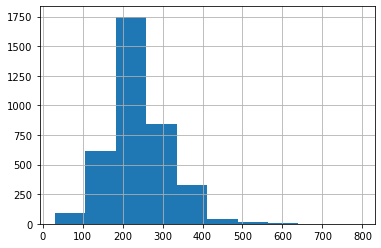

In [16]:
count.hist()

<AxesSubplot:>

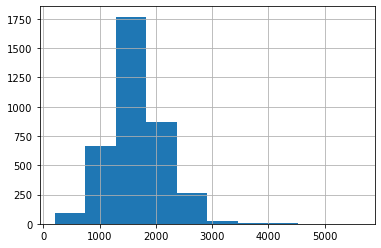

In [17]:
# character counts
test_len = df['abstract'].apply(len)
test_len.sort_values(ascending=True)
test_len.hist()

In [19]:


# #showing the list of shortest abstract
# print(df['abstract'][512595]) # maybe not the best articles but does contain plant-based foods # shortest ones 
# print(df['abstract'][22205]) # cochrane review - relevant for vegan diet and CVD precention 
# print(df['abstract'][10481]) # diet issues for veg inpatients may have 
# print(df['abstract'][321426]) # plant-based mentioned once but related to vaccine production.
# print(df['abstract'][13154]) # plant based diet impacts on CAD 

In [20]:
 #extracting only those ab has more than 400 words
more_400_keywords = df[df['abstract'].apply(lambda x: len(x.split()) > 400)]
more_400_keywords.info() # 80 entries so we will keep it all 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 75 to 22896
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pmc       72 non-null     object
 1   title     72 non-null     object
 2   abstract  72 non-null     object
dtypes: object(3)
memory usage: 2.2+ KB


In [21]:
#extracting only those ab has less than 100 
less_100_keywords = df[df['abstract'].apply(lambda x: len(x.split()) < 100)]
less_100_keywords.info() # 87 entries so we will keep it all 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 183 to 22642
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pmc       71 non-null     object
 1   title     71 non-null     object
 2   abstract  71 non-null     object
dtypes: object(3)
memory usage: 2.2+ KB


After reviewing the abstracts, the decision is made to include those abstracts that includes 27-792 words (512595).

In [22]:
pd.set_option('display.max_colwidth', None)

In [23]:
alphanumeric_remove = lambda x: re.sub('\w*\d\w*', ' ', x) #remove numbers
punctuation_remove = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x) #remove punctuation

df['abstract_clean'] = df['abstract'].map(alphanumeric_remove).map(punctuation_remove)

In [30]:
# function to preprocess abstract cleaning

def clean(text):

    #removing punc
#     text = re.sub('\W+',' ', str(text))
#     text = re.sub('[^A-Za-z0-9]+', ' ', str(text))
#     text = re.sub('[%s]', ' ', str(text)) # % re.escape(string.punctuation), ' ', str(text)) # new one that was not rerun
     text = re.sub('[%s]'% re.escape(string.punctuation), ' ', str(text)) 
# #    text = re.escape((text.punctuation), ' ', str(text)) 


    # removing numbers
    text = re.sub('\w*\d\w*',r' ',str(text))
    #text = text.replace('\w*\d\w*',' ')#,str(text))
    
    # removing new line characters
    #text = re.sub('\n ','',str(text))
    #text = re.sub('\n',' ',str(text))
    # removing apostrophes
#     text = re.sub("\'s ",' ',str(text))

        # removing hyphens
    text = re.sub('-',' ',str(text))
    text = re.sub('- ',' ',str(text))
    text = re.sub(' – ',' ',str(text))  
    text = text.replace('—',' ')
    
    # removing quotation marks
    text = re.sub('\”',' ',str(text))
    # removing quotation marks
    text = re.sub('\“',' ',str(text))
    # removing less or equal to marks
    text = re.sub('\≤',' ',str(text))
    text = re.sub('\≥',' ',str(text))
    text = re.sub('\±',' ',str(text))  
    text = re.sub('\×',' ',str(text))
    text = re.sub('\∼',' ',str(text))
    text = re.sub('\%',' ',str(text))
    text = text.replace('%',' ')
    text = text.replace('=',' ')
    text = text.replace('+',' ')
 
    
    # removing brackets marks
    text = re.sub('\[',' ',str(text))
    text = re.sub('\]',' ',str(text))
        # removing parenthesis marks
    text = re.sub('\(',' ',str(text))
    text = re.sub('\)',' ',str(text))
    # removing quotation marks
    text = re.sub('\“',' ',str(text))
    # removing less or equal to marks
    text = re.sub('\≤',' ',str(text)) 
    

    # removing dot marks
    text = re.sub('\·',' ',str(text)) 
#     # removing salutations
#     text = re.sub("Mr\.",'Mr',str(text))
#     text = re.sub("Mrs\.",'Mrs',str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", ' ', str(text))
    #remove numbers
    text = re.sub(r'\d+', r' ', str(text))
    text = re.sub(r'[0-9]+', r' ', str(text)) 
    #duplicates space
#     text = re.sub(r"\s+", r' ', str(text))  
#     text = re.sub(r"^\s+|\s+$", r' ', str(text))  
    


    return text
# # preprocessing abstracts
# df['abstract'] = df['abstract'].apply(clean)
# df['abstract'] = df['abstract'].astype(str).str.lower()

In [266]:
# df.drop(['abstract_clean'], axis=1, inplace=True)

In [31]:
df['abstract_clean'] = df['abstract_clean'].apply(clean)
df['abstract_clean'] = df['abstract_clean'].astype(str).str.lower()

In [32]:
df.sample(5)

,pmc,title,abstract,abstract_clean
18982,PMC7222840,"Effects of Dietary β-Mannanase Supplementation on Growth Performance, Apparent Total Tract Digestibility, Intestinal Integrity, and Immune Responses in Weaning Pigs.","Simple Summary: Many plant-based feedstuffs contain non-digestible factors, such as β-mannans, that may reduce growth performance, as well as energy and nutrient digestibility. However, weaning pigs lack enzymes—such as β-mannanase—necessary to more completely digest β-mannan. Therefore, this experiment aimed to investigate the effects of dietary β-mannanase supplementation on growth performance, apparent total tract digestibility of nutrients, intestinal integrity and the immunological and oxidative stress parameters of weaning pigs. Our result suggested that adding β-mannanase to the weaning pigs’ diet increased the apparent total tract digestibility (ATTD) of ether extract, jejunum villus height, and villus height-to-crypt depth ratio, and lowered crypt depth compared with those fed the no-β-mannanase diet. This study indicated that the inclusion of β-mannanase showed the potential to improve fat digestibility, intestinal development and gut health of weaning pigs. Abstract: The experiment aimed to investigate the effects of dietary β-mannanase supplementation on growth performance, apparent total tract digestibility (ATTD) of nutrients, intestinal integrity, and the immunological and oxidative stress parameters in weaning pigs. A total of 64 newly weaning pigs (initial body weight: 6.96 ± 0.70 kg) were allotted to two dietary treatments in eight replicates per treatment with four pigs per pen based on body weight and sex. Dietary treatments were 1.) CON (control: corn-soybean meal based basal diet) and 2.) β-mannanase (basal diet +0.06% β-mannanase). The β-mannanase supplementation did not affect growth performance, concentrations of acute phase protein, superoxide dismutase and glutathione peroxidase. However, the pigs fed the β-mannanase-supplemented diet had greater ATTD of ether extract, jejunum villus height, and villus height-to-crypt depth ratio, and lower crypt depth compared with those fed the CON diet (p < 0.05). The pigs fed the β-mannanase-supplemented diet tended to have the lower count of E. coli in cecum than those fed the CON diet (p = 0.08). In conclusion, dietary β-mannanase supplementation did not affect growth performance, immune response and oxidative stress of weaning pigs, whereas it increased fat digestibility and had positive effects on intestinal integrity and cecum microflora by reducing the count of E.coli.",simple summary many plant based feedstuffs contain non digestible factors such as β mannans that may reduce growth performance as well as energy and nutrient digestibility however weaning pigs lack enzymes such as β mannanase necessary to more completely digest β mannan therefore this experiment aimed to investigate the effects of dietary β mannanase supplementation on growth performance apparent total tract digestibility of nutrients intestinal integrity and the immunological and oxidative stress parameters of weaning pigs our result suggested that adding β mannanase to the weaning pigs’ diet increased the apparent total tract digestibility attd of ether extract jejunum villus height and villus height to crypt depth ratio and lowered crypt depth compared with those fed the no β mannanase diet this study indicated that the inclusion of β mannanase showed the potential to improve fat digestibility intestinal development and gut health of weaning pigs abstract the experiment aimed to investigate the effects of dietary β mannanase supplementation on growth performance apparent total tract digestibility attd of nutrients intestinal integrity and the immunological and oxidative stress parameters in weaning pigs a total of newly weaning pigs initial body weight kg were allotted to two dietary treatments in eight replicates per treatment with four pigs per pen based on body weight 

In [ ]:
df.loc[136,'abstract_clean']

In [ ]:
df.loc[136,'abstract_clean']# 136 1541 check those two 

In [273]:
df.columns

Index(['pmc', 'title', 'abstract', 'abstract_clean'], dtype='object')

In [21]:
# stoo words
# acron CVD 
# basic rules - domain knowledge  to remove ci p 
# high context... helpful... unhelpful....

stop_words = ['' , '', '', ]

#create your custom stop words list
my_stop_words = ['her','me','i','she','it']
words = [word for word in text.split() if word.lower() not in my_stop_words]
new_text = " ".join(words)
print(new_text)
print("Old length: ", len(text))
print("New length: ", len(new_text))


#extend stop words
sw_nltk.extend(['first', 'second', 'third', 'me'])
print(len(sw_nltk))


import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

In [33]:
df2=df.copy()

In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3684 entries, 0 to 56020
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   pmc             3684 non-null   object
 1   title           3684 non-null   object
 2   abstract        3684 non-null   object
 3   abstract_clean  3684 non-null   object
dtypes: object(4)
memory usage: 272.9+ KB


In [221]:
df['abstract_clean'][11702]

' liquiritigenin is a chiral flavonoid present in plant based food  nutraceuticals  and traditional medicines  it is also an important ingredient present in licorice  the purpose of this study is to explore the pharmacological activity of racemic liquiritigenin utilizing several in vitro assays with relevant roles in colon cancer and diabetes  where possible  the pure enantiomers were tested to identify the stereospecific contribution to the activity  in vitro antioxidant  anticancer  anti inflammatory activities  cyclooxygenase inhibition   antidiabetic activities  alpha amylase and alpha glucosidase inhibition  as well as cytochrome       inhibitory activities were assessed  racemic liquiritigenin demonstrated a dose dependent inhibition of alpha amylase enzyme whereas its pure enantiomers did not  racemic liquiritigenin showed moderate antiproliferative activity on a ht    human colorectal adenocarcinoma  cancer cell line that was dose dependent and potent inhibitory effects on the 

In [242]:
# df2.sample(2)

In [250]:
df.loc[5298,'abstract_clean']

' high oil prices global warming accompany use fossil fuels incentive alternative forms energy supply  photosynthetic biofuel production represents  uses renewable resources  sunlight conversion water   biomass  strategies parallel  plant based production sugar fermentation ethanol biodiesel production transesterification    exacerbate problems  including regional nutrient balancing world food supply  suffer modest efficiency photosynthesis  maximizing efficiency natural engineered photosynthesis utmost importance  algal photosynthesis choice particularly energy applications  complete conversion   biomass necessary  innovative methods synthetic biology allow combine photosynthetic fermentative metabolism called photanol approach form biofuel directly calvin cycle intermediates use naturally transformable cyanobacterium synechocystis sp  pcc    providing transport energy chemical feedstocks  photosynthesis continue food feed applications  application  arguments efficiency important size

11702     32
5298      36
150       42
923       44
17642     46
        ... 
1137     597
884      598
7158     608
22710    633
6370     801
Name: abstract_clean, Length: 3684, dtype: int64


<AxesSubplot:>

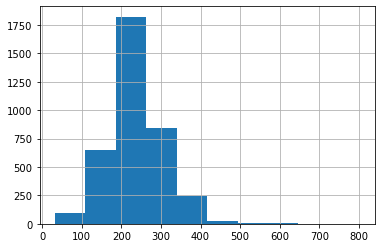

In [35]:
count2 = df2['abstract_clean'].str.split().str.len()
count2.index = count.index.astype(str)
#count.sort_index(inplace = True)
count2.sort_values(ascending = True,inplace = True)
print(count2)
count2.hist()# 27 and 792 and now it is 16 and 469(265 after stop words removed)  ## updated corpus resulted the same 16 and 465

stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vec = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
vec_train = vec.fit_transform(df2.body)

Included gensim stopwords
'should', 'mine', 'yourselves', 'whatever', 'alone', 'km', 'nevertheless', 'thru', 'whence', 'whenever', 'nobody', 'who', 'so', 'put', 'amount', 'since', 'say', 'become', 'thereafter', 'there', 'though', 'yet', 'nothing', 'over', 'about', 'no', 'they', 'regarding', 'that', 'all', 'might', 'towards', 'were', 'what', 'yourself', 'indeed', 'him', 'five', 'latter', 'moreover', 'least', 'whereupon', 'empty', 'twenty', 'being', 'its', 'within', 'across', 'and', 'cry', 'until', 'eleven', 'below', 'see', 'less', 'without', 'latterly', 'former', 'beyond', 'formerly', 'each', 'by', 'very', 'give', 'once', 'under', 'side', 'seemed', 'thence', 'beforehand', 'nine', 'could', 'amongst', 'find', 'computer', 'up', 'this', 'off', 'via', 'beside', 'using', 'ltd', 'are', 'therein', 'fifty', 'even', 'only', 'thereby', 'then', 'more', 'co', 'cannot', 'would', 'much', 'perhaps', 'us', 'anything', 'at', 'everyone', 're', 'down', 'whereby', 'not', 'go', 'am', 'afterwards', 'does', 'did', 'elsewhere', 'our', 'make', 'eight', 'to', 'last', 'too', 'his', 'became', 'i', 'such', 'other', 'in', 'due', 'back', 'either', 'everything', 'why', 'call', 'becoming', 'around', 'another', 'four', 'been', 'yours', 'sometime', 'please', 'into', 'hence', 'besides', 'ten', 'ourselves', 'mill', 'fill', 'just', 'against', 'had', 'full', 'have', 'here', 'with', 'above', 'although', 'show', 'herself', 'whereafter', 'me', 'don', 'well', 'always', 'the', 'but', 'of', 'every', 'get', 'same', 'be', 'becomes', 'thick', 'still', 'these', 'on', 'myself', 'anywhere', 'detail', 'someone', 'thin', 'kg', 'between', 'before', 'top', 'among', 'something', 'during', 'while', 'thereupon', 'for', 'has', 'bill', 'interest', 'move', 'fire', 'anyhow', 'your', 'own', 'twelve', 'con', 'wherein', 'except', 'through', 'seeming', 'etc', 'third', 'themselves', 'nowhere', 'again', 'whereas', 'many', 'their', 'ever', 'thus', 'name', 'hereby', 'from', 'couldnt', 'along', 'six', 'than', 'doing', 'whose', 'herein', 'hereupon', 'didn', 'doesn', 'sometimes', 'whoever', 'keep', 'used', 'enough', 'upon', 'if', 'together', 'made', 'out', 'mostly', 'one', 'where', 'onto', 'eg', 'really', 'she', 'itself', 'must', 'inc', 'as', 'anyway', 'bottom', 'he', 'namely', 'front', 'de', 'ours', 'whither', 'hundred', 'everywhere', 'those', 'un', 'my', 'few', 'may', 'quite', 'often', 'wherever', 'meanwhile', 'when', 'himself', 'will', 'somehow', 'can', 'noone', 'now', 'cant', 'fifteen', 'various', 'serious', 'amoungst', 'seems', 'whom', 'some', 'unless', 'whether', 'anyone', 'done', 'both', 'them', 'we', 'which', 'none', 'hers', 'almost', 'whole', 'do', 'was', 'several', 'however', 'otherwise', 'nor', 'a', 'first', 'behind', 'most', 'forty', 'found', 'seem', 'else', 'part', 'toward', 'take', 'it', 'sincere', 'also', 'two', 'never', 'already', 'others', 'somewhere', 'next', 'her', 'rather', 'after', 'sixty', 'because', 'or', 'hereafter', 'is', 'an', 'hasnt', 'describe', 'per', 'any', 'throughout', 'you', 'ie', 'three', 'therefore', 'how', 'system', 'further', 'neither'

## gensim stopwords
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
print(STOPWORDS)

new_text = remove_stopwords(text)
print(new_text)
print("Old length: ", len(text))
print("New length: ", len(new_text))

#check what are the stop words by default
sw_nltk = stopwords.words('english')
print(sw_nltk)

In [36]:
df2.sample(2)

,pmc,title,abstract,abstract_clean
2687,PMC8407220,"Study protocol: long-term effect of the New Nordic Renal Diet on phosphorus and lipid homeostasis in patients with chronic kidney disease, stages 3 and 4: a randomised controlled trial.","Introduction: Chronic kidney disease (CKD) causes severe disturbances in phosphate metabolism. New Nordic Renal Diet (NNRD) is a new dietary concept designed by the present research group that aims to offer patients with moderate CKD a whole food approach with a markedly reduction in dietary phosphorus intake, corresponding to 850 mg/day. The present protocol describes a randomised controlled trial aiming to test the long-term effects of dietary intervention with NNRD versus a non-restricted habitual diet on important parameters of phosphorus and lipid homeostasis. Methods and analysis: This trial will be executed at the Department of Nephrology, Rigshospitalet, University of Copenhagen, Denmark. Sixty patients aged >18 years with CKD stages 3 and 4 (estimated glomerular filtration rate between 15 and 45 mL/min) will be recruited and randomly assigned to the intervention or control group. The other inclusion criterion includes a medically stable condition for at least 2 months prior to the start of the study. Exclusion criteria are treatment with phosphate binders, metabolic disorders that require specific dietary regulation, pregnancy and breast feeding, any types of food allergies or those who are vegans. The observation period is 26 weeks including seven study visits at the outpatient clinic combined with a weekly telephone consultation in both groups. A follow-up visit 3 months after study completion finalises the intervention. The primary outcome is the difference in the change in 24-hour urine phosphorus excretion from baseline to week 26 between the two study groups. Secondary outcomes include changes in phosphate-related and lipid metabolism-related blood and urine biochemistry, blood pressure and body composition. Moreover, we wish to explore adherence to the diet as well as quality of life. Ethics and dissemination: The study has been approved by the Scientific Ethical Committee of the Capital Region of Denmark and the Danish Data Protection Agency. The results of the studies will be presented at national and international scientific meetings, and publications will be submitted to peer-reviewed journals. Trial registration number: ClinicalTrials.gov (wwwclinicaltrialsgov) Registry (NCT04579315). Protocol version: The protocol, version 2, has been approved by the Ethical Committee Denmark on 18 September 2020. The protocol has also been approved by Data Protection Regulation and Data Protection Law on 15 September 2020. This study protocol is in accordance with the Standard Protocol Items: Recommendations for International Trials.",introduction chronic kidney disease ckd causes severe disturbances in phosphate metabolism new nordic renal diet nnrd is a new dietary concept designed by the present research group that aims to offer patients with moderate ckd a whole food approach with a markedly reduction in dietary phosphorus intake corresponding to mg day the present protocol describes a randomised controlled trial aiming to test the long term effects of dietary intervention with nnrd versus a non restricted habitual diet on important parameters of phosphorus and lipid homeostasis methods and analysis this trial will be executed at the department of nephrology rigshospitalet university of copenhagen denmark sixty patients aged years with ckd stages and estimated glomerular filtration rate between and ml min will be recruited and randomly assigned to the intervention or control group the other inclusion criterion includes a medically stable condition for at least months prior to the start of the study exclusion criteria are treatment with phosphate binders metabolic disorders that require specific dietary regulation pregnancy and breast feeding any types of food allergies or those who

In [48]:
#df['abstract'][81595] #remove rf, h p n p lf rf mm hg

In [38]:
#df2.to_pickle("abstract_clean_stripped.pkl")  
#df = pd.read_pickle("abstract_clean_stripped.pkl")    #maybe not to use this version

In [44]:
df2['abstract_tokenized'] = df2['abstract_clean'].apply(word_tokenize)

In [278]:
# df.drop([#'abstract_tokenized',
#        'abstract_tagged'], axis=1, inplace=True)
df.columns

Index(['pmc', 'title', 'abstract', 'abstract_clean'], dtype='object')

In [257]:
len(df['abstract_tokenized'][8])

322

In [58]:
#df['abstract_tokenized'][8] # check on whether to remove the b in vitamin b

In [258]:
len(df['abstract_tokenized'])

3684

count3 = df['abstract_tokenized'].str.len()
count3.index = count3.index.astype(str)
#count.sort_index(inplace = True)
count3.sort_values(ascending = True,inplace = True)
print(count3)

In [282]:
# df['abstract'][22205]#shortest
#df['abstract'][64055] longest

In [43]:
df2['abstract_clean'][1]

' the aim of the study was to investigate the prevalence of  and attitudes toward  vegetarianism and veganism  we also assessed the association between vegetarianism veganism and eating disorder  depressive  and somatic symptoms  a cross sectional questionnaire survey in adults in germany that was representative in terms of age  gender  and educational level was carried out  data from   adults       females  were included  mean age was      sd      years  a total of      of participants reported following a vegetarian or vegan diet  while the majority of participants agreed that vegetarian diets are healthy and harmless         only      believed this to be true of vegan diets  the majority of participants also believed that a vegetarian        or vegan        diet can lead to nutritional deficiency  female gender  younger age  higher education  lower body mass index  bmi   and higher depressive and eating disorder symptoms were found to be associated with vegetarianism veganism  we di

# tried to remove none english words but it removed some real terms in med/biology
words = set(nltk.corpus.words.words())  #set of English words 
df2['abstract_tokenized']=df2['abstract_tokenized'].apply(lambda x: [item for item in x if item in words])

df2=df.copy()
count4 = df2['abstract_tokenized'].str.len()
count4.index = count4.index.astype(str)
#count.sort_index(inplace = True)
count4.sort_values(ascending = True,inplace = True)
print(count4)  # count how many words were cut and identified those should not be removed

### Apply part of speech tagger

In [45]:
#tagging words with parts of speech 
df2['abstract_tagged'] = pos_tag_sents(df2['abstract_tokenized'].tolist()) 

In [91]:
#df2['abstract_tagged'][8][1][1]

'VBN'

 # check out this
def findtags(tag_prefix, tagged_text):
    cfd = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_text
                                  if tag.startswith(tag_prefix))
    return dict((tag, cfd[tag].most_common(5)) for tag in cfd.conditions())

>>> tagdict = findtags('NN', nltk.corpus.brown.tagged_words(categories='news'))
>>> for tag in sorted(tagdict):
...     print(tag, tagdict[tag])

In [46]:
df2['abstract_tagged'][1] # maybe remove adverb

[('the', 'DT'),
 ('aim', 'NN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('study', 'NN'),
 ('was', 'VBD'),
 ('to', 'TO'),
 ('investigate', 'VB'),
 ('the', 'DT'),
 ('prevalence', 'NN'),
 ('of', 'IN'),
 ('and', 'CC'),
 ('attitudes', 'NNS'),
 ('toward', 'IN'),
 ('vegetarianism', 'NN'),
 ('and', 'CC'),
 ('veganism', 'NN'),
 ('we', 'PRP'),
 ('also', 'RB'),
 ('assessed', 'VBD'),
 ('the', 'DT'),
 ('association', 'NN'),
 ('between', 'IN'),
 ('vegetarianism', 'NN'),
 ('veganism', 'NN'),
 ('and', 'CC'),
 ('eating', 'VBG'),
 ('disorder', 'NN'),
 ('depressive', 'NN'),
 ('and', 'CC'),
 ('somatic', 'JJ'),
 ('symptoms', 'NNS'),
 ('a', 'DT'),
 ('cross', 'NN'),
 ('sectional', 'JJ'),
 ('questionnaire', 'NN'),
 ('survey', 'NN'),
 ('in', 'IN'),
 ('adults', 'NNS'),
 ('in', 'IN'),
 ('germany', 'NN'),
 ('that', 'WDT'),
 ('was', 'VBD'),
 ('representative', 'JJ'),
 ('in', 'IN'),
 ('terms', 'NNS'),
 ('of', 'IN'),
 ('age', 'NN'),
 ('gender', 'NN'),
 ('and', 'CC'),
 ('educational', 'JJ'),
 ('level', 'NN'),
 ('was', 'VBD')

In [261]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### Removing adverb RB

In [47]:
#creating a mini function to remove adverbs # decided not to remove proper noun e.g. 
def remove_adv(tagged_text):
    return [(word, tag) for word,tag in tagged_text if tag != 'RB'] #keeping tag for lemmatizing
# def remove_nounp(tagged_text):
#     return [(word, tag) for word,tag in tagged_text if tag != 'NNP'] #keeping tag for lemmatizing



In [48]:
#applying the remove adverb function I devided not to remove adv and nnp
df2['abstract_tagged_no_adv'] = df2['abstract_tagged'].apply(remove_adv)#.apply(remove_nounp)


In [49]:
df2.columns

Index(['pmc', 'title', 'abstract', 'abstract_clean', 'abstract_tokenized',
       'abstract_tagged', 'abstract_tagged_no_adv'],
      dtype='object')

### Lemmatizing

In [50]:
#creating a function to convert post_tags to WordNet friendly tags, then lemmatizing
def lemmatize_all(tagged_text):
    doc_lemm = []
    wnl = WordNetLemmatizer()
    for word, tag in (tagged_text):
        if tag.startswith("NN"):
            doc_lemm.append(wnl.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('VB'):
            doc_lemm.append(wnl.lemmatize(word, wordnet.VERB))
        elif tag.startswith('JJ'):
            doc_lemm.append(wnl.lemmatize(word, wordnet.ADJ))
        else:
            doc_lemm.append(word)
    return doc_lemm

In [51]:
#applying the lemmatization function
df2['abstract_lemm'] = df2['abstract_tagged_no_adv'].apply(lemmatize_all)

In [53]:
# df2['abstract_lemm']

In [297]:
df.columns

Index(['pmc', 'title', 'abstract', 'abstract_clean', 'abstract_tokenized',
       'abstract_tagged', 'abstract_tagged_no_adv', 'abstract_lemm'],
      dtype='object')

In [293]:
#df.drop['abstract_lemm',inplace =True]

<ipython-input-293-3b0079ef874f>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['abstract_lemm'] = df['abstract_lemm'].str.replace('.', '')


In [55]:
# if you want to add additional words, use .union(['word']), 
# where word = a word you want to add as a stop word
add_words = ['©','°c',';','(',')','copyright','ii','s','mm','hg','iii','iiii','iv','xi','h','n', 'p', 'lf' ,'rf','should', 'mine', 'yourselves', 'whatever', 'alone', 'km', 
             'nevertheless', 'thru', 'whence', 'whenever', 'nobody', 'who', 'so', 'put', 'amount', 'since', 'say', 'become', 'thereafter', 'there', 'though', 'yet', 'nothing', 
             'over', 'about', 'no', 'they', 'regarding', 'that', 'all', 'might', 'towards', 'were', 'what', 'yourself', 'indeed', 'him', 'five', 'latter', 'moreover', 'least', 
             'whereupon', 'empty', 'twenty', 'being', 'its', 'within', 'across', 'and', 'cry', 'until', 'eleven', 'below', 'see', 'less', 'without', 'latterly', 'former', 
             'beyond', 'formerly', 'each', 'by', 'very', 'give', 'once', 'under', 'side', 'seemed', 'thence', 'beforehand', 'nine', 'could', 'amongst', 'find', 'computer', 'up', 'this', 'off', 
             'via', 'beside', 'using', 'ltd', 'are', 'therein', 'fifty', 'even', 'only', 'thereby', 'then', 'more', 'co', 'cannot', 'would', 'much', 'perhaps', 'us', 'anything', 'at', 'everyone', 're', 
             'down', 'whereby', 'not', 'go', 'am', 'afterwards', 'does', 'did', 'elsewhere', 'our', 'make', 'eight', 'to', 'last', 'too', 'his', 'became', 'i', 'such', 'other', 'in', 'due', 'back', 
             'either', 'everything', 'why', 'call', 'becoming', 'around', 'another', 'four', 'been', 'yours', 'sometime', 'please', 'into', 'hence', 'besides', 'ten', 'ourselves', 'mill', 'fill', 'just', 
             'against', 'had', 'full', 'have', 'here', 'with', 'above', 'although', 'show', 'herself', 'whereafter', 'me', 'don', 'well', 'always', 'the', 'but', 'of', 'every', 'get', 'same', 'be', 'becomes', 
             'thick', 'still', 'these', 'on', 'myself', 'anywhere', 'detail', 'someone', 'thin', 'kg', 'between', 'before', 'top', 'among', 'something', 'during', 'while', 'thereupon', 'for', 'has', 'bill',  
             'move', 'fire', 'anyhow', 'your', 'own', 'twelve', 'con', 'wherein', 'except', 'through', 'seeming', 'etc', 'third', 'themselves', 'nowhere', 'again', 'whereas', 'many', 'their', 'ever', 'thus',
             'name', 'hereby', 'from', 'couldnt', 'along', 'six', 'than', 'doing', 'whose', 'herein', 'hereupon', 'didn', 'doesn', 'sometimes', 'whoever', 'keep', 'used', 'enough', 'upon', 'if', 'together', 
             'made', 'out', 'mostly', 'one', 'where', 'onto', 'eg', 'really', 'she', 'itself', 'must', 'inc', 'as', 'anyway', 'bottom', 'he', 'namely', 'front', 'de', 'ours', 'whither', 'hundred', 'everywhere', 
             'those', 'un', 'my', 'few', 'may', 'quite', 'often', 'wherever', 'meanwhile', 'when', 'himself', 'will', 'somehow', 'can', 'noone', 'now', 'cant', 'fifteen', 'various', 'serious', 'amoungst', 
             'seems', 'whom', 'some', 'unless', 'whether', 'anyone', 'done', 'both', 'them', 'we', 'which', 'none', 'hers', 'almost', 'whole', 'do', 'was', 'several', 'however', 'otherwise', 'nor', 'a', 
             'first', 'behind', 'most', 'forty', 'found', 'seem', 'else', 'part', 'toward', 'take', 'it', 'sincere', 'also', 'two', 'never', 'already', 'others', 'somewhere', 'next', 'her', 'rather', 'after', 
             'sixty', 'because', 'or', 'hereafter', 'is', 'an', 'hasnt', 'describe', 'per', 'any', 'throughout', 'you', 'ie', 'three', 'therefore', 'how', 'system', 'further', 'neither'] 
# gensim stopwords added
stop_words = ENGLISH_STOP_WORDS.union(add_words)
df2['abstract_stopwords'] = df2['abstract_lemm'].apply(lambda x: ' '.join([word for word in x if word not in stop_words]))

In [57]:
df2['abstract_modeling'] = df2['abstract_stopwords'].apply(word_tokenize)

In [59]:
df2.to_pickle("abstracts_for_modeling_final.pkl")  
#df = pd.read_pickle("abstracts_for_modeling_final.pkl") 

In [79]:
## maybe used for future ones, right now it is too aggressive 
# df3=df.copy()
# def stem_text(text):
#     doc_stemmed = []
#     stemmer = LancasterStemmer()
    
#     for word in text:
#         doc_stemmed.append(stemmer.stem(word))
        
#     return doc_stemmed
# df3['abstract_stemmed'] = df3['abstract_tokenized'].apply(stem_text)
# df3['abstract_stemmed'][8]
# df_stem=df3
# #df_stem.to_pickle("stem_abstract.pkl")  
#df = pd.read_pickle("stem_abstract.pkl") 

# Notes for self are below

# import re
#re.findall('one', text) # \w. words.   \d digits    '[ab]' match a OR b eg '[od]ne' eg '1\d+'
 
small_df = pf.DataFrame([[1, 'hello'],[2,'bye']], columns = ['num','text'])

small_df.text = small_Df.text.map(lambda x: re.sub('e','E', x))


# punctuation
df.reviews = df.reviews.map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

df.reviews = df.reviews.map(lambda x: re.sub('<br />', ' ', x)) # special characteristics 

# capital letters 
check
assert len(re.findall('[A-Z]+',df.reviews.to_string())) == 0,
# numbers
# stop words (little semantic meaning)

## example for stop words
example_sentence = 'this is an example showing off stop word filtration.'
stop_words = set(stopwords.words('english'))
words = word_tokenize(example_sentence)
filtered_sentence = []

for w in words:
    if w not in stop_words:
        filtered_sentence.append(w)
filtered_sentence

filtered_sentence = [w for w in words if not w in stop_words]

## tokenize
import re
def tokenization(text):
    tokens = re.split('W+',text)
    return tokens
#applying function to the column
data['msg_tokenied']= data['msg_lower'].apply(lambda x: tokenization(x))